Run 385738: original LS 1 -> 1738, applying LS offset 0
Run 385739: original LS 1 -> 434, applying LS offset 1738
14.098277777777913
Saved fill10116_rates.pdf, fill10116_rates.jpg


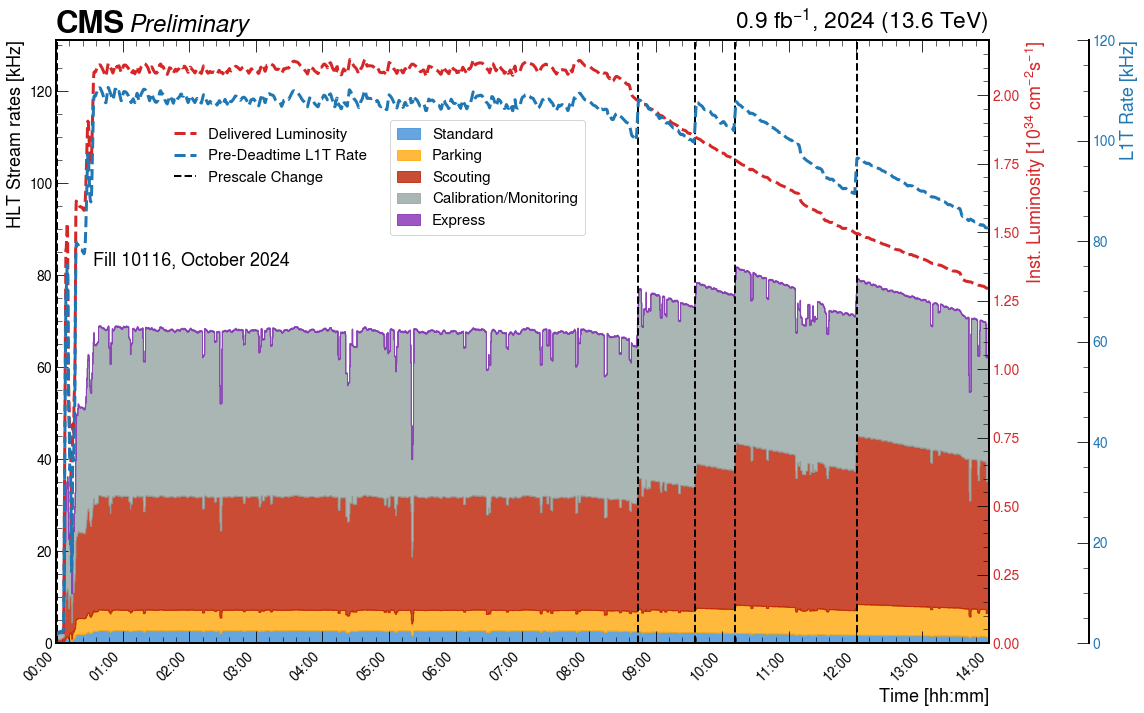

In [1]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH     = "fill_10116.json"
RUNS = {
    "385738": 51, #Run : LS cut , only consider LSs greater than this value
    "385739": 1,
}
SMOOTH_WINDOW = 5
OUTPUT_PDF    = "fill10116_rates.pdf"
OUTPUT_JPG    = "fill10116_rates.jpg"
YEAR          = 2024
LUMI_LABEL    = 0.9
CMS_ENERGY    = 13.6

PRESCALE_LSES = [1, 1349, 1483, 1575, 1849] #LSs with prescale column change
IGNORE_LSES   = [1273,1274,1730,1731,1732,1733,1734,1735,1736,1737,1738] #ignore these LSs

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):  #smoothening function. larger window size = greater smoothening
    arr = np.array(data, dtype=float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / float(window_size)

def classify_stream(name):
    if name.startswith("Physics"):   return "Standard"
    if name.startswith("Parking"):   return "Parking"
    if name.startswith("Scouting"):  return "Scouting"
    if name.startswith("Express"):   return "Express"
    if name.startswith(("ALCA","Calibration")) or (name.startswith("DQM") and name!="DQMHistograms") or name.startswith("NanoDST"):
        return "Calibration/Monitoring"
    return None

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h) * 60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, LS_CUT in RUNS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        print(f"Run {run} not found, skipping.")
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries]
    if not all_ls:
        print(f"No LS found for run {run}, skipping.")
        continue

    last_ls = max(all_ls)
    print(f"Run {run}: original LS 1 -> {last_ls}, applying LS offset {ls_offset}")

    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found after cut!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate per-lumisection
# -----------------------------------------------------------------------------
cats          = ["Standard","Parking","Scouting","Calibration/Monitoring","Express"]
summed        = {c: {} for c in cats}
deliv         = {}
l1raw         = {}
pre_deadtime  = {}
times_ls      = {}

for stream, entries in run_data.items():
    cat = classify_stream(stream)
    if not cat:
        continue

    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in times_ls:
            times_ls[ls] = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")

        summed[cat].setdefault(ls, 0.0)
        summed[cat][ls] += e["rate"] / 1000.0  # Hz → kHz

        deliv.setdefault(ls, e["delivered_lumi_per_lumisection"])

        if ls not in l1raw and "hlt_rate_Status_OnGPU" in e:
            l1raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1raw:
            dt = e["deadtime"]
            pre_deadtime[ls] = l1raw[ls] / (1 - dt) if dt < 1 else l1raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays & smooth
# -----------------------------------------------------------------------------
ls_sorted = sorted(times_ls)

rates = {c: [summed[c].get(ls, 0.0) for ls in ls_sorted] for c in cats}
lumi   = [deliv[ls] for ls in ls_sorted]
l1rate = [pre_deadtime.get(ls, 0.0) for ls in ls_sorted]

times_arr = [
    (times_ls[ls] - t0).total_seconds() / 3600.0
    for ls in ls_sorted
]

rates_sm = {c: moving_average(rates[c]) for c in cats}
lumi_sm  = moving_average(lumi)
l1_sm    = moving_average(l1rate)
time_sm  = moving_average(times_arr)

L = min(
    *(len(rates_sm[c]) for c in cats),
    len(lumi_sm),
    len(l1_sm),
    len(time_sm)
)
for c in cats:
    rates_sm[c] = rates_sm[c][:L]
lumi_sm = lumi_sm[:L]
l1_sm   = l1_sm[:L]
time_sm = time_sm[:L]

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16,10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

# --- stacked streams ---
area_handles, area_labels = [], []
cum = np.zeros(L)
colors = ["#3f90da","#ffa90e","#bd1f01","#94a4a2","#832db6"]
for cat, col in zip(cats, colors):
    h = ax1.fill_between(time_sm,
                         cum, cum + rates_sm[cat],
                         step="mid", alpha=0.8, color=col)
    area_handles.append(h)
    area_labels.append(cat)
    cum += rates_sm[cat]

# --- Prescale transitions ---
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        x = time_sm[max(0, idx - (SMOOTH_WINDOW // 2))]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("HLT Stream rates [kHz]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.99)
print(time_sm[-1])
ax1.set_ylim(0, cum.max()*1.6)
ax1.tick_params(labelsize=14)

ax1.set_xticks(np.arange(0, np.floor(time_sm[-1]) + 1, 1.0))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(
    0.04, 0.65,
    f"Fill 10116, October 2024",
    transform=ax1.transAxes,
    fontsize=18,
    verticalalignment="top"
)

# --- delivered lumi (red line) ---
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm * 100/23.31,
                       color="tab:red", linewidth=3, linestyle="--",
                       label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]",
               color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0, 2.2)

# --- pre-deadtime L1 (blue line) ---
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 100))
l1_handle, = ax3.plot(time_sm, l1_sm,
                      color="tab:blue", linewidth=3, linestyle="--",
                      label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0, 120)

# --- legends ---
leg1 = ax1.legend(area_handles, area_labels,
                  loc="upper left",
                  bbox_to_anchor=(0.35, 0.88),
                  frameon=True,
                  framealpha=0.8,
                  fontsize=15,
                  title_fontsize=18)
ax1.add_artist(leg1)

extra_labels = [lum_handle, l1_handle]
extra_names = ["Delivered Luminosity", "Pre-Deadtime L1T Rate"]
if prescale_handle:
    extra_labels.append(prescale_handle)
    extra_names.append("Prescale Change")

leg2 = ax1.legend(extra_labels, extra_names,
                  loc="upper right",
                  bbox_to_anchor=(0.35, 0.88),
                  fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


Run 385738: original LS 1 -> 1738, applying LS offset 0
Run 385739: original LS 1 -> 434, applying LS offset 1738
Saved fill10116_bandwidth.pdf, fill10116_bandwidth.jpg


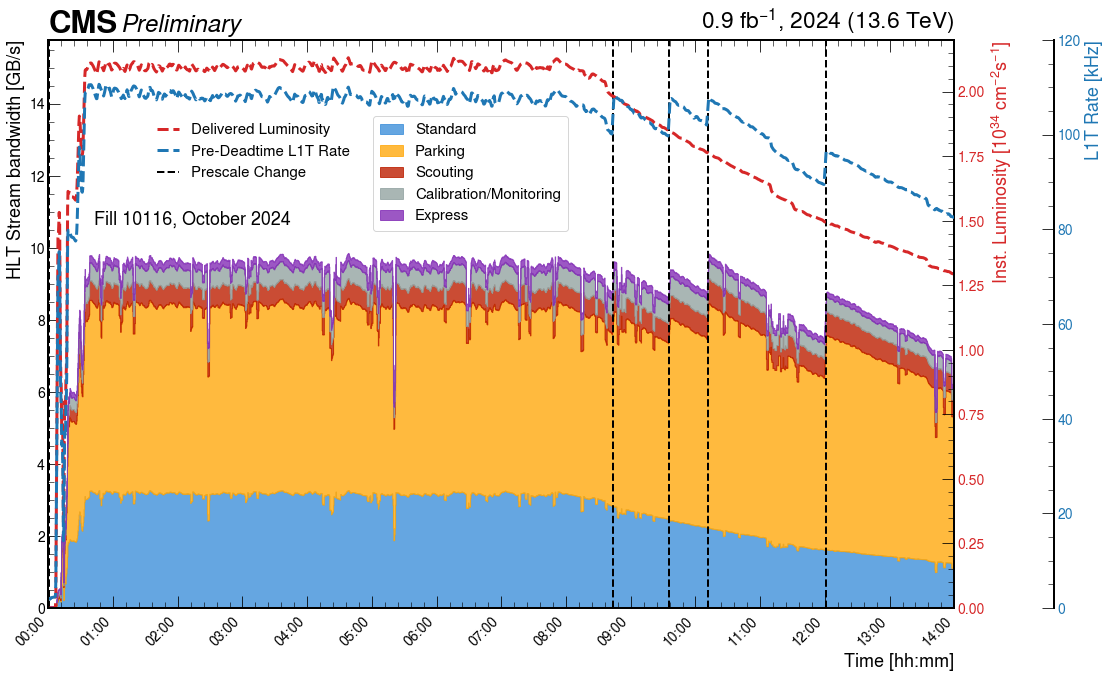

In [2]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH     = "fill_10116.json"
RUNS = {
    "385738": 51,
    "385739": 1,
}
SMOOTH_WINDOW = 5
OUTPUT_PDF    = "fill10116_bandwidth.pdf"
OUTPUT_JPG    = "fill10116_bandwidth.jpg"
YEAR          = 2024
LUMI_LABEL    = 0.9
CMS_ENERGY    = 13.6

PRESCALE_LSES = [1, 1349, 1483, 1575, 1849]
IGNORE_LSES   = [1273,1274,1730,1731,1732,1733,1734,1735,1736,1737,1738]

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, dtype=float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / float(window_size)

def classify_stream(name):
    if name.startswith("Physics"):   return "Standard"
    if name.startswith("Parking"):   return "Parking"
    if name.startswith("Scouting"):  return "Scouting"
    if name.startswith("Express"):   return "Express"
    if name.startswith(("ALCA","Calibration")) or (name.startswith("DQM") and name!="DQMHistograms") or name.startswith("NanoDST"):
        return "Calibration/Monitoring"
    return None

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h) * 60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, LS_CUT in RUNS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        print(f"Run {run} not found, skipping.")
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries]
    if not all_ls:
        print(f"No LS found for run {run}, skipping.")
        continue

    last_ls = max(all_ls)
    print(f"Run {run}: original LS 1 -> {last_ls}, applying LS offset {ls_offset}")

    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found after cut!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate per-lumisection
# -----------------------------------------------------------------------------
cats          = ["Standard","Parking","Scouting","Calibration/Monitoring","Express"]
summed        = {c: {} for c in cats}
deliv         = {}
l1raw         = {}
pre_deadtime  = {}
times_ls      = {}

for stream, entries in run_data.items():
    cat = classify_stream(stream)
    if not cat:
        continue

    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in times_ls:
            times_ls[ls] = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")

        # --- Bandwidth instead of rate ---
        summed[cat].setdefault(ls, 0.0)
        summed[cat][ls] += e.get("bandwidth", 0.0) / 1e9  # bytes/sec → GB/sec

        deliv.setdefault(ls, e["delivered_lumi_per_lumisection"])

        if ls not in l1raw and "hlt_rate_Status_OnGPU" in e:
            l1raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1raw:
            dt = e["deadtime"]
            pre_deadtime[ls] = l1raw[ls] / (1 - dt) if dt < 1 else l1raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays & smooth
# -----------------------------------------------------------------------------
ls_sorted = sorted(times_ls)

rates = {c: [summed[c].get(ls, 0.0) for ls in ls_sorted] for c in cats}
lumi   = [deliv[ls] for ls in ls_sorted]
l1rate = [pre_deadtime.get(ls, 0.0) for ls in ls_sorted]

times_arr = [
    (times_ls[ls] - t0).total_seconds() / 3600.0
    for ls in ls_sorted
]

rates_sm = {c: moving_average(rates[c]) for c in cats}
lumi_sm  = moving_average(lumi)
l1_sm    = moving_average(l1rate)
time_sm  = moving_average(times_arr)

L = min(
    *(len(rates_sm[c]) for c in cats),
    len(lumi_sm),
    len(l1_sm),
    len(time_sm)
)
for c in cats:
    rates_sm[c] = rates_sm[c][:L]
lumi_sm = lumi_sm[:L]
l1_sm   = l1_sm[:L]
time_sm = time_sm[:L]

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16,10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

# --- stacked streams ---
area_handles, area_labels = [], []
cum = np.zeros(L)
colors = ["#3f90da","#ffa90e","#bd1f01","#94a4a2","#832db6"]
for cat, col in zip(cats, colors):
    h = ax1.fill_between(time_sm,
                         cum, cum + rates_sm[cat],
                         step="mid", alpha=0.8, color=col)
    area_handles.append(h)
    area_labels.append(cat)
    cum += rates_sm[cat]

# --- Prescale transitions ---
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        x = time_sm[max(0, idx - (SMOOTH_WINDOW // 2))]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("HLT Stream bandwidth [GB/s]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.99)
ax1.set_ylim(0, cum.max()*1.6)
ax1.tick_params(labelsize=14)

ax1.set_xticks(np.arange(0, np.floor(time_sm[-1]) + 1, 1.0))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(
    0.05, 0.7,
    f"Fill 10116, October 2024",
    transform=ax1.transAxes,
    fontsize=18,
    verticalalignment="top"
)

# --- delivered lumi (red line) ---
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm * 100/23.31,
                       color="tab:red", linewidth=3, linestyle="--",
                       label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]",
               color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0, 2.2)

# --- pre-deadtime L1 (blue line) ---
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 100))
l1_handle, = ax3.plot(time_sm, l1_sm,
                      color="tab:blue", linewidth=3, linestyle="--",
                      label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0, 120)

# --- legends ---
leg1 = ax1.legend(area_handles, area_labels,
                  loc="upper left",
                  bbox_to_anchor=(0.35, 0.88),
                  frameon=True,
                  framealpha=0.8,
                  fontsize=15,
                  title_fontsize=18)
ax1.add_artist(leg1)

extra_labels = [lum_handle, l1_handle]
extra_names = ["Delivered Luminosity", "Pre-Deadtime L1T Rate"]
if prescale_handle:
    extra_labels.append(prescale_handle)
    extra_names.append("Prescale Change")

leg2 = ax1.legend(extra_labels, extra_names,
                  loc="upper right",
                  bbox_to_anchor=(0.35, 0.88),
                  fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


Run 385738: original LS 1 -> 1738, applying LS offset 0
Run 385739: original LS 1 -> 434, applying LS offset 1738
14.098277777777913
Saved fill10116_physics_bandwidth.pdf, fill10116_physics_bandwidth.jpg


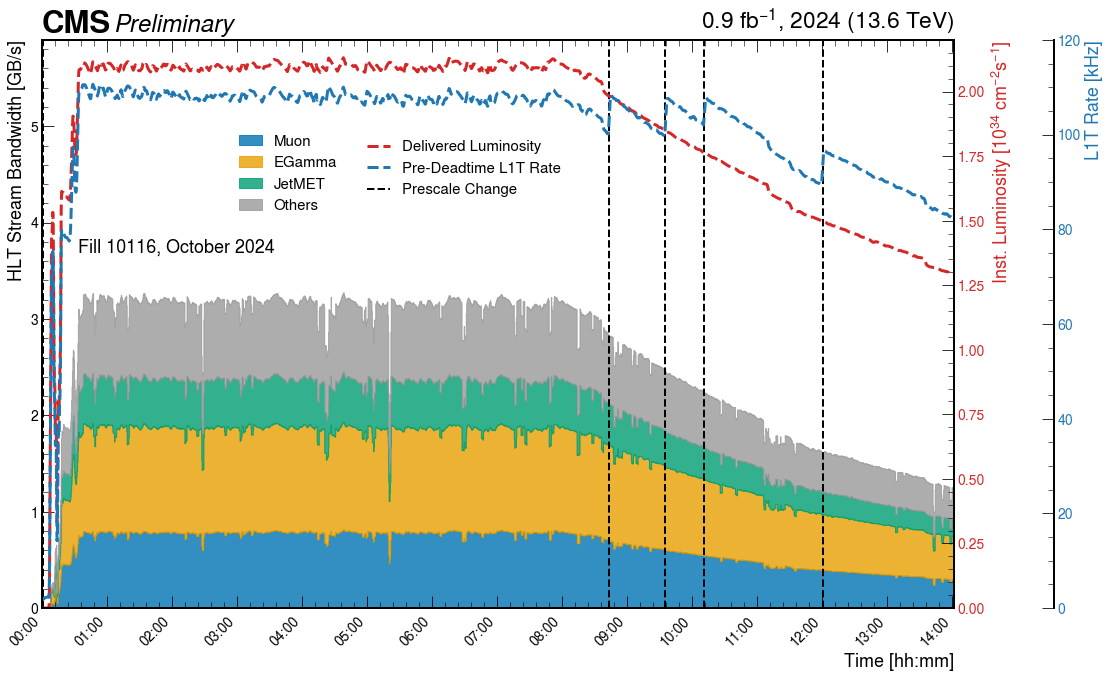

In [3]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH      = "fill_10116.json"
RUNS = {
    "385738": 51,
    "385739": 1,
}
SMOOTH_WINDOW  = 5
OUTPUT_PDF     = "fill10116_physics_bandwidth.pdf"
OUTPUT_JPG     = "fill10116_physics_bandwidth.jpg"
YEAR           = 2024
LUMI_LABEL     = 0.9
CMS_ENERGY     = 13.6
PRESCALE_LSES  = [1, 1349, 1483, 1575, 1849]
IGNORE_LSES    = [1273,1274,1730,1731,1732,1733,1734,1735,1736,1737,1738]

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / window_size

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h) * 60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and apply LS offset for multiple runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, LS_CUT in RUNS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        print(f"Run {run} not found, skipping.")
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries]
    if not all_ls:
        print(f"No LS found for run {run}, skipping.")
        continue

    last_ls = max(all_ls)
    print(f"Run {run}: original LS 1 -> {last_ls}, applying LS offset {ls_offset}")

    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0 (earliest LS after cuts)
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found after cut!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate per LS
# -----------------------------------------------------------------------------
bandwidth_by_stream = {}
deliv_lumi = {}
l1rate_raw = {}
ls_time    = {}
pre_deadtime_l1 = {}

for stream, entries in run_data.items():
    if not stream.startswith("Physics") or "HLTPhysics" in stream or "ZeroBias" in stream:
        continue

    bandwidth_by_stream.setdefault(stream, {})
    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in ls_time:
            ts = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
            ls_time[ls] = ts
            deliv_lumi[ls] = e["delivered_lumi_per_lumisection"]

        # Use bandwidth (in bytes/sec), convert to GB/sec
        bandwidth_by_stream[stream][ls] = e.get("bandwidth", 0.0) / 1e9

        if ls not in l1rate_raw and "hlt_rate_Status_OnGPU" in e:
            l1rate_raw[ls] = e["hlt_rate_Status_OnGPU"] / 1000.0

        if "deadtime" in e and ls in l1rate_raw:
            dt = e["deadtime"]
            pre_deadtime_l1[ls] = l1rate_raw[ls] / (1-dt) if dt < 1 else l1rate_raw[ls]

# -----------------------------------------------------------------------------
# Build arrays
# -----------------------------------------------------------------------------
ls_sorted = sorted(ls_time)
time_arr = [(ls_time[ls]-t0).total_seconds()/3600.0 for ls in ls_sorted]

streams = sorted(bandwidth_by_stream)
bandwidth = {s: [bandwidth_by_stream[s].get(ls,0.0) for ls in ls_sorted] for s in streams}
lumi = [deliv_lumi[ls] for ls in ls_sorted]
l1r  = [pre_deadtime_l1.get(ls,0.0) for ls in ls_sorted]

# Smooth
time_sm = moving_average(time_arr)
bandwidth_sm = {s: moving_average(bandwidth[s]) for s in streams}
lumi_sm = moving_average(lumi)
l1_sm = moving_average(l1r)

# Align sizes
L = min(len(time_sm), len(lumi_sm), len(l1_sm), *(len(bandwidth_sm[s]) for s in streams))
time_sm = time_sm[:L]
lumi_sm = lumi_sm[:L]
l1_sm   = l1_sm[:L]
for s in streams:
    bandwidth_sm[s] = bandwidth_sm[s][:L]

# -----------------------------------------------------------------------------
# Group streams
# -----------------------------------------------------------------------------
groups = {
    'Others': [s for s in streams if not any(x in s for x in ('Muon','EGamma','JetMET'))],
    'Muon':   [s for s in streams if 'Muon' in s],
    'EGamma': [s for s in streams if 'EGamma' in s],
    'JetMET': [s for s in streams if 'JetMET' in s],
}

colors = {
    'Others': '#999999',
    'Muon':   '#0072B2',
    'EGamma': '#E69F00',
    'JetMET': '#009E73',
}

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16,10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

cumul, handles, labels = np.zeros(L), [], []

for name in ['Muon','EGamma','JetMET','Others']:
    ysum = sum(bandwidth_sm[s] for s in groups[name])
    h = ax1.fill_between(time_sm, cumul, cumul+ysum,
                         step="mid", alpha=0.8, color=colors[name], label=name)
    handles.append(h)
    labels.append(name)
    cumul += ysum

# Prescale change lines
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        i = ls_sorted.index(ls)
        j = max(0, i-(SMOOTH_WINDOW-1))
        x = time_sm[j]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color='black', linestyle='--', linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color='black', linestyle='--', linewidth=2)

# Axes
ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("HLT Stream Bandwidth [GB/s]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.995)
print(time_sm[-1])
ax1.set_ylim(0, cumul.max()*1.8)
ax1.tick_params(labelsize=14)

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(
    data=True, year=YEAR, lumi=LUMI_LABEL,
    loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24
)

ax1.text(
    0.04, 0.65,
    f"Fill 10116, October 2024",
    transform=ax1.transAxes,
    fontsize=18,
    verticalalignment="top"
)

# Lumi
ax2 = ax1.twinx()
lum_handle, = ax2.plot(
    time_sm, lumi_sm * 100/23.31,
    color="tab:red", linestyle="--", linewidth=3,
    label="Delivered Luminosity"
)
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]",
               color="tab:red", fontsize=18)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0,2.2)

# L1 Rate
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward",100))
l1_handle, = ax3.plot(
    time_sm, l1_sm,
    color="tab:blue", linestyle="--", linewidth=3,
    label="Pre-Deadtime L1T Rate"
)
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0,120)

# Legends
leg1 = ax1.legend(handles, labels, loc="upper left", fontsize=15, bbox_to_anchor=(0.20, 0.86))
ax1.add_artist(leg1)

leg2 = ax1.legend([lum_handle, l1_handle, prescale_handle],
                  ["Delivered Luminosity", "Pre-Deadtime L1T Rate", "Prescale Change"],
                  loc="upper left", bbox_to_anchor=(0.34, 0.85), fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


Run 385738: original LS 1 -> 1738, applying LS offset 0
Run 385739: original LS 1 -> 434, applying LS offset 1738
Saved fill10116_physics_rates.pdf, fill10116_physics_rates.jpg


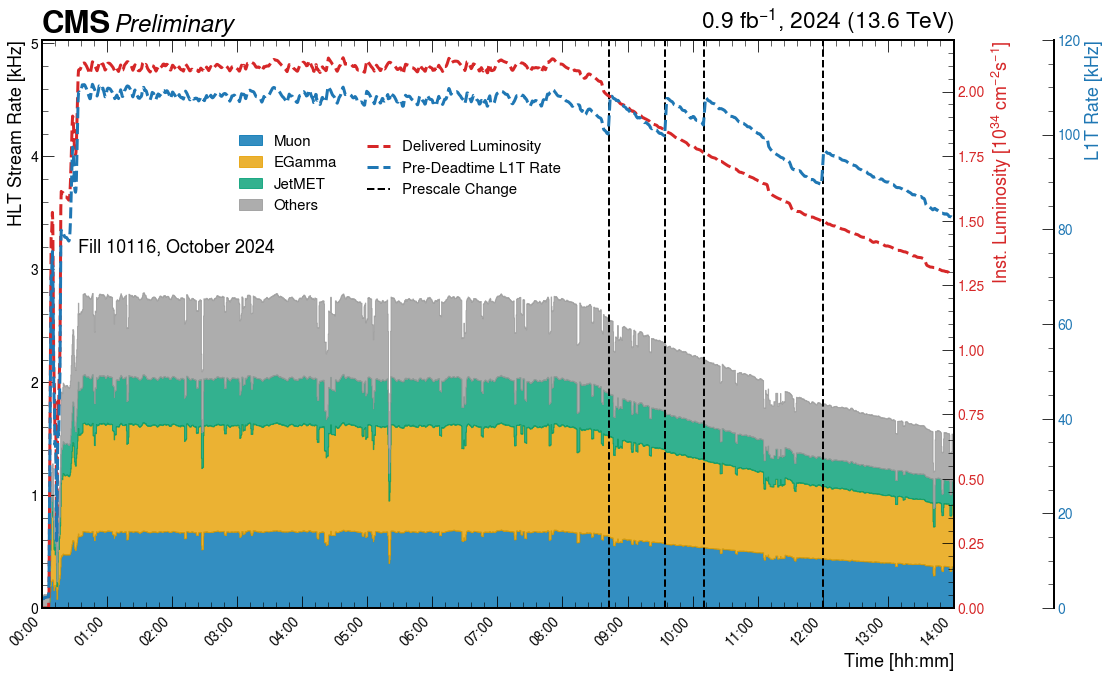

In [4]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH      = "fill_10116.json"
RUNS = {
    "385738": 51,
    "385739": 1,   # example second run
    # add more runs here!
}
#LS_CUT         = 30
SMOOTH_WINDOW  = 5
OUTPUT_PDF     = "fill10116_physics_rates.pdf"
OUTPUT_JPG     = "fill10116_physics_rates.jpg"
YEAR           = 2024
LUMI_LABEL     = 0.9
CMS_ENERGY     = 13.6
PRESCALE_LSES  = [1, 1349, 1483, 1575,1849]
IGNORE_LSES = [1273,1274,1730,1731,1732,1733,1734,1735,1736,1737,1738]

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / window_size

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h)*60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and find t0
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0
run_ls_offsets = {}  # for later if needed

for run, LS_CUT in RUNS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        print(f"Run {run} not found in JSON, skipping.")
        continue

    all_ls = []
    for entries in run_data.values():
        for e in entries:
            all_ls.append(e["LS"])

    if not all_ls:
        print(f"No LS found for run {run}")
        continue

    last_ls = max(all_ls)
    run_ls_offsets[run] = ls_offset
    print(f"Run {run}: original LS 1 -> {last_ls}, applying LS offset {ls_offset}")

    # Now shift and merge entries
    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls  # update for next run

run_data = corrected_run_data

all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > LS_CUT
]
if not all_times:
    raise RuntimeError("No LS > LS_CUT found")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate per‐stream, per‐LS
# -----------------------------------------------------------------------------
rates_by_stream = {}
deliv_lumi      = {}
l1rate_raw      = {}
ls_time         = {}
pre_deadtime_l1 = {}

for stream, entries in run_data.items():
    if not stream.startswith("Physics") or "HLTPhysics" in stream or "ZeroBias" in stream:
        continue
    rates_by_stream.setdefault(stream, {})
    for e in entries:
        ls = e["LS"]
       # print(ls)
        if ls <= LS_CUT or ls in IGNORE_LSES:
            continue
        if ls not in ls_time:
            ts = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
            ls_time[ls]   = ts
            deliv_lumi[ls] = e["delivered_lumi_per_lumisection"]
        rates_by_stream[stream][ls] = e["rate"]/1000.0
        if ls not in l1rate_raw and "hlt_rate_Status_OnGPU" in e:
            l1rate_raw[ls] = e["hlt_rate_Status_OnGPU"]/1000.0
        if "deadtime" in e and ls in l1rate_raw:
            dt = e["deadtime"]
            pre_deadtime_l1[ls] = (
                l1rate_raw[ls]/(1-dt) if dt<1 else l1rate_raw[ls]
            )

# -----------------------------------------------------------------------------
# Build arrays & smooth
# -----------------------------------------------------------------------------
ls_sorted = sorted(ls_time)
time_arr  = [(ls_time[ls]-t0).total_seconds()/3600.0 for ls in ls_sorted]

streams = sorted(rates_by_stream)
rates   = {s: [rates_by_stream[s].get(ls,0.0) for ls in ls_sorted] for s in streams}
lumi    = [deliv_lumi[ls] for ls in ls_sorted]
l1r     = [pre_deadtime_l1.get(ls,0.0) for ls in ls_sorted]

time_sm  = moving_average(time_arr)
rates_sm = {s: moving_average(rates[s]) for s in streams}
lumi_sm  = moving_average(lumi)
l1_sm    = moving_average(l1r)

L = min(len(time_sm), len(lumi_sm), len(l1_sm), *(len(rates_sm[s]) for s in streams))
time_sm = time_sm[:L]
lumi_sm = lumi_sm[:L]
l1_sm   = l1_sm[:L]
for s in streams:
    rates_sm[s] = rates_sm[s][:L]

# -----------------------------------------------------------------------------
# Define grouping and colors
# -----------------------------------------------------------------------------
groups = {
    'Others':      [s for s in streams if not any(x in s for x in ('Muon','EGamma','JetMET'))],
    'Muon':        [s for s in streams if 'Muon' in s],
    'EGamma':      [s for s in streams if 'EGamma' in s],
    'JetMET':      [s for s in streams if 'JetMET' in s],
}

colors = {
    'Others': '#999999',
    'Muon':   '#0072B2',   # blue
    'EGamma': '#E69F00',   # orange instead of yellow
    'JetMET': '#009E73',   # bluish‑green instead of lime
}

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16,10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

cumul, handles, labels = np.zeros(L), [], []

# plot each group once
for name in ['Muon','EGamma','JetMET','Others']:
    ysum = sum(rates_sm[s] for s in groups[name])
    h = ax1.fill_between(time_sm, cumul, cumul+ysum,
                         step="mid", alpha=0.8,
                         color=colors[name], label=name)
    handles.append(h)
    labels.append(name)
    cumul += ysum

# draw prescale‐change lines & capture one handle
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        i = ls_sorted.index(ls)
        j = max(0, i-(SMOOTH_WINDOW-1))
        x = time_sm[j]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(
                x, color='black', linestyle='--', linewidth=2,
                label="Prescale change"
            )
        else:
            ax1.axvline(x, color='black', linestyle='--', linewidth=2)

# axes formatting
ax1.set_xlabel("Time [hh:mm]", fontsize=18)
ax1.set_ylabel("HLT Stream Rate [kHz]", fontsize=18)
ax1.set_xlim(0, time_sm[-1]*0.995)
ax1.set_ylim(0, cumul.max()*1.8)
ax1.tick_params(labelsize=14)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")


hep.cms.label(
    data=True, year=YEAR, lumi=LUMI_LABEL,
    loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24
)

ax1.text(
    0.04, 0.65,
    f"Fill 10116, October 2024",
    transform=ax1.transAxes,
    fontsize=18,
    verticalalignment="top"
)

# delivered lumi (dashed red)
ax2 = ax1.twinx()
lum_handle, = ax2.plot(
    time_sm, lumi_sm*100/23.31,
    color="tab:red", linestyle="--", linewidth=3,
    label="Delivered Luminosity"
)
ax2.set_ylabel(
    "Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]",
    color="tab:red", fontsize=18
)
ax2.tick_params(labelcolor="tab:red", labelsize=14)
ax2.set_ylim(0,2.2)

# pre‑deadtime L1 (dashed blue)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward",100))
l1_handle, = ax3.plot(
    time_sm, l1_sm,
    color="tab:blue", linestyle="--", linewidth=3,
    label="Pre-Deadtime L1T Rate"
)
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=18)
ax3.tick_params(labelcolor="tab:blue", labelsize=14)
ax3.set_ylim(0,120)

# -----------------------------------------------------------------------------
# Legends
# -----------------------------------------------------------------------------
leg1 = ax1.legend(
    handles, labels,
    loc="upper left",
    fontsize=15,
    bbox_to_anchor=(0.20, 0.86),
)
ax1.add_artist(leg1)

leg2 = ax1.legend(
    [lum_handle, l1_handle, prescale_handle],
    ["Delivered Luminosity", "Pre-Deadtime L1T Rate", "Prescale Change"],
    loc="upper left",
    bbox_to_anchor=(0.34, 0.85),
    fontsize=15
)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


14.098277777777913
Saved fill10116_parking.pdf, fill10116_parking.jpg


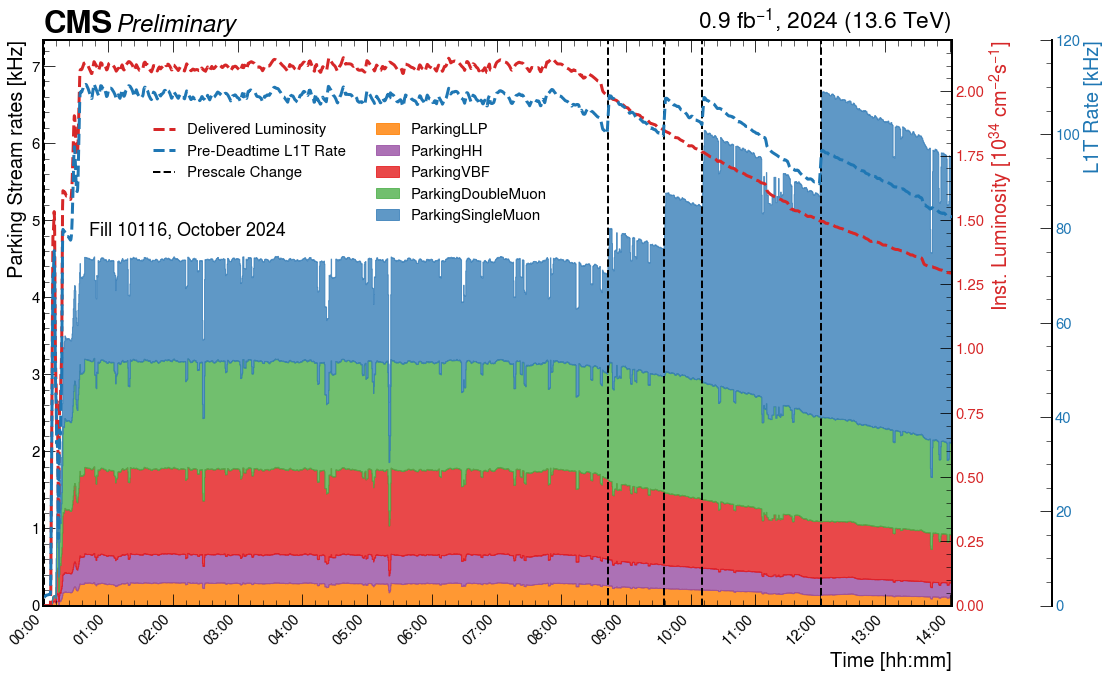

In [5]:
#!/usr/bin/env python3
import json
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FuncFormatter

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
JSON_PATH      = "fill_10116.json"
RUNS = {
    "385738": 51,
    "385739": 1,
}
SMOOTH_WINDOW  = 5
OUTPUT_PDF     = "fill10116_parking.pdf"
OUTPUT_JPG     = "fill10116_parking.jpg"
YEAR           = 2024
LUMI_LABEL     = 0.9
CMS_ENERGY     = 13.6

PRESCALE_LSES  = [1, 1349, 1483, 1575, 1849]
IGNORE_LSES    = [1273,1274,1730,1731,1732,1733,1734,1735,1736,1737,1738]

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def moving_average(data, window_size=SMOOTH_WINDOW):
    arr = np.array(data, float)
    if len(arr) < window_size:
        return np.array([])
    csum = np.cumsum(np.insert(arr, 0, 0.0))
    return (csum[window_size:] - csum[:-window_size]) / window_size

def canonical_name(name):
    """Merge ParkingSingleMuonX → ParkingSingleMuon etc"""
    for base in ["ParkingSingleMuon", "ParkingDoubleMuon", "ParkingVBF"]:
        if name.startswith(base):
            return base
    return name

def hhmm_fmt(x, pos=None):
    h = int(x)
    m = int(round((x - h)*60))
    return f"{h:02d}:{m:02d}"

# -----------------------------------------------------------------------------
# Load JSON and merge runs
# -----------------------------------------------------------------------------
with open(JSON_PATH) as fp:
    all_data = json.load(fp)

corrected_run_data = {}
ls_offset = 0

for run, LS_CUT in RUNS.items():
    run_data = all_data.get(run, {})
    if not run_data:
        continue

    all_ls = [e["LS"] for entries in run_data.values() for e in entries]
    if not all_ls:
        continue

    last_ls = max(all_ls)

    for stream, entries in run_data.items():
        corrected_run_data.setdefault(stream, [])
        for e in entries:
            e = e.copy()
            e["LS"] += ls_offset
            corrected_run_data[stream].append(e)

    ls_offset += last_ls

run_data = corrected_run_data

# -----------------------------------------------------------------------------
# Find t0
# -----------------------------------------------------------------------------
all_times = [
    datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
    for entries in run_data.values() for e in entries
    if e["LS"] > 0 and e["LS"] not in IGNORE_LSES
]
if not all_times:
    raise RuntimeError("No good LS found after cut!")
t0 = min(all_times)

# -----------------------------------------------------------------------------
# Aggregate streams
# -----------------------------------------------------------------------------
summed_rates = {}
deliv_lumi   = {}
l1rate_raw   = {}
ls_time      = {}
pre_deadtime_l1 = {}

for stream, entries in run_data.items():
    if not stream.startswith("Parking"):
        continue

    base_name = canonical_name(stream)

    for e in entries:
        ls = e["LS"]
        if ls <= 0 or ls in IGNORE_LSES:
            continue

        if ls not in ls_time:
            ls_time[ls] = datetime.strptime(e["start_time"], "%Y-%m-%dT%H:%M:%SZ")
            deliv_lumi[ls] = e["delivered_lumi_per_lumisection"]

        summed_rates.setdefault(base_name, {})
        summed_rates[base_name][ls] = summed_rates[base_name].get(ls, 0.0) + e["rate"]/1000.0

        if ls not in l1rate_raw and "hlt_rate_Status_OnGPU" in e:
            l1raw = e["hlt_rate_Status_OnGPU"]/1000.0
            l1rate_raw[ls] = l1raw

        if "deadtime" in e and ls in l1rate_raw:
            dt = e["deadtime"]
            pre_deadtime_l1[ls] = l1rate_raw[ls]/(1-dt) if dt < 1 else l1rate_raw[ls]

# -----------------------------------------------------------------------------
# Build sorted arrays
# -----------------------------------------------------------------------------
ls_sorted = sorted(ls_time)
time_arr = [(ls_time[ls]-t0).total_seconds()/3600.0 for ls in ls_sorted]

# Desired stream stacking order
ordered_streams = ["ParkingLLP","ParkingHH","ParkingVBF","ParkingDoubleMuon","ParkingSingleMuon"]

rates = {s: [summed_rates.get(s, {}).get(ls, 0.0) for ls in ls_sorted] for s in ordered_streams}
lumi   = [deliv_lumi[ls] for ls in ls_sorted]
l1r    = [pre_deadtime_l1.get(ls, 0.0) for ls in ls_sorted]

time_sm  = moving_average(time_arr)
rates_sm = {s: moving_average(rates[s]) for s in ordered_streams}
lumi_sm  = moving_average(lumi)
l1_sm    = moving_average(l1r)

L = min(len(time_sm), len(lumi_sm), len(l1_sm), *(len(rates_sm[s]) for s in ordered_streams))
time_sm = time_sm[:L]
lumi_sm = lumi_sm[:L]
l1_sm   = l1_sm[:L]
for s in ordered_streams:
    rates_sm[s] = rates_sm[s][:L]

# -----------------------------------------------------------------------------
# Define custom colors
# -----------------------------------------------------------------------------
colors = {
    "ParkingSingleMuon": "#377eb8",   # blue
    "ParkingDoubleMuon": "#4daf4a",   # green
    "ParkingHH":         "#984ea3",   # purple
    "ParkingLLP":        "#ff7f00",   # orange
    "ParkingVBF":        "#e41a1c",   # red
}

# -----------------------------------------------------------------------------
# Plot
# -----------------------------------------------------------------------------
plt.style.use(hep.style.CMS)
fig, ax1 = plt.subplots(figsize=(16,10))
fig.subplots_adjust(left=0.30, right=0.78, top=0.88)

cumul = np.zeros(L)
handles, labels = [], []

for s in ordered_streams:
    h = ax1.fill_between(time_sm, cumul, cumul + rates_sm[s],
                         step="mid", alpha=0.8, color=colors[s], label=s)
    handles.append(h)
    labels.append(s)
    cumul += rates_sm[s]

# Prescale lines
prescale_handle = None
for ls in PRESCALE_LSES:
    if ls in ls_sorted:
        idx = ls_sorted.index(ls)
        j = max(0, idx - (SMOOTH_WINDOW-1))
        x = time_sm[j]
        if prescale_handle is None:
            prescale_handle = ax1.axvline(x, color="black", linestyle="--", linewidth=2, label="Prescale Change")
        else:
            ax1.axvline(x, color="black", linestyle="--", linewidth=2)

# Axes
ax1.set_xlabel("Time [hh:mm]", fontsize=20)
ax1.set_ylabel("Parking Stream rates [kHz]", fontsize=20)
ax1.set_xlim(0, time_sm[-1]*0.995)
print(time_sm[-1])
ax1.set_ylim(0, cumul.max()*1.1)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FuncFormatter(hhmm_fmt))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

hep.cms.label(data=True, year=YEAR, lumi=LUMI_LABEL,
              loc=0, ax=ax1, com=CMS_ENERGY, label="Preliminary", fontsize=24)

ax1.text(0.05, 0.68, f"Fill 10116, October 2024",
         transform=ax1.transAxes, fontsize=18, verticalalignment="top")

# Delivered lumi
ax2 = ax1.twinx()
lum_handle, = ax2.plot(time_sm, lumi_sm*100/23.31,
                       color="tab:red", linestyle="--", linewidth=3, label="Delivered Luminosity")
ax2.set_ylabel("Inst. Luminosity [$10^{34}$ cm$^{-2}$s$^{-1}$]", color="tab:red", fontsize=20)
ax2.tick_params(labelcolor="tab:red", labelsize=15)
ax2.set_ylim(0, 2.2)

# L1 rate
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 100))
l1_handle, = ax3.plot(time_sm, l1_sm,
                      color="tab:blue", linestyle="--", linewidth=3, label="Pre-Deadtime L1T Rate")
ax3.set_ylabel("L1T Rate [kHz]", color="tab:blue", fontsize=20)
ax3.tick_params(labelcolor="tab:blue", labelsize=15)
ax3.set_ylim(0, 120)

# Legends
leg1 = ax1.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, 0.88), fontsize=15)
ax1.add_artist(leg1)

leg2 = ax1.legend([lum_handle, l1_handle, prescale_handle],
                  ["Delivered Luminosity", "Pre-Deadtime L1T Rate", "Prescale Change"],
                  loc="upper right", bbox_to_anchor=(0.35, 0.88), fontsize=15)

plt.tight_layout()
fig.savefig(OUTPUT_PDF, dpi=1200)
fig.savefig(OUTPUT_JPG, dpi=1200)
print(f"Saved {OUTPUT_PDF}, {OUTPUT_JPG}")


In [6]:
14.098277777777913

14.098277777777913